In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
#create the colormap we want: white -> blue -> red

colors = [(1, 1, 1), (0.78, 0.84, 0.94), (0.92, 0.69, 0.65)]  # R -> G -> B
n_bins = 20  # Discretizes the interpolation into bins
cmap_name = 'white_blue_red'

# Create the colormap
cmap_wbr = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# N-acyl lipids tail body distribution - Humans (Supplementary Figure 2c)

In [3]:
#import fastmasst results merged with ReDU - after fultering with cosine > 0.7
df = pd.read_csv('/.../humans_all_heads_matches_cos07_ReDU_unfiltered07.tsv', sep='\t')

#and create a new column for the chain length
df['tail'] = df['group_annotation'].str.split('-').str[-1]

#and standardize some UBERONBodyPartName names (combining skin and blood)
df['UBERONBodyPartName'] = df['UBERONBodyPartName'].str.replace('skin of trunk','skin')
df['UBERONBodyPartName'] = df['UBERONBodyPartName'].str.replace('skin of pes','skin')
df['UBERONBodyPartName'] = df['UBERONBodyPartName'].str.replace('head or neck skin','skin')
df['UBERONBodyPartName'] = df['UBERONBodyPartName'].str.replace('axilla skin','skin')
df['UBERONBodyPartName'] = df['UBERONBodyPartName'].str.replace('skin of manus','skin')
df['UBERONBodyPartName'] = df['UBERONBodyPartName'].str.replace('arm skin','skin')
df['UBERONBodyPartName'] = df['UBERONBodyPartName'].str.replace('blood plasma','blood')
df['UBERONBodyPartName'] = df['UBERONBodyPartName'].str.replace('blood serum','blood')

# and remove the ones that will not be informative 
list_remove = ['not applicable', 'not specified', 'ML import: not available'] 
df = df[~df['UBERONBodyPartName'].str.lower().isin(list_remove)]


In [4]:
# Lets get a table with the number of occurrences of each delta_mass per head in microbemasst

#select both groups that we want to plot in the heatmap
yaxis = 'UBERONBodyPartName'       
xaxis = 'Head'

# Group the dataframe by 'Head' and 'delta_mass_round' and count the occurrences
grouped_df = df.groupby([yaxis, xaxis]).size().reset_index(name='count')

# Pivot the grouped dataframe to have 'Head' as columns, 'delta_mass_round' as rows, and 'count' as values
pivot_table = grouped_df.pivot(index = xaxis, columns = yaxis, values='count').fillna(0)

# Reset the index if you want 'delta_mass_round' as a column, not an index
pivot_table.reset_index(inplace=True)
pivot_table.head()

UBERONBodyPartName,Head,anal region,blood,brain,cerebrospinal fluid,feces,milk,nasal cavity,oral cavity,saliva,skin,urine,vagina
0,2-aminovaleric acid,0.0,8.0,0.0,0.0,229.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,2-phenethylamine,1.0,0.0,0.0,0.0,112.0,0.0,0.0,205.0,1.0,33.0,0.0,9.0
2,3-methoxytyramine,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3-methylhistidine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5-methoxytryptamine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0


In [5]:
# then we need to transpose the dataframe
pivot_table_t = pivot_table.T
pivot_table_t = pivot_table_t.reset_index()
pivot_table_t.columns = pivot_table_t.iloc[0]
pivot_table_t = pivot_table_t[1:]

# to plot counts, we need to convert from object to integer
columns_to_convert = pivot_table_t.columns[1:]
pivot_table_t[columns_to_convert] = pivot_table_t[columns_to_convert].astype(int)
pivot_table_t = pivot_table_t.reset_index()
columns_for_heatmap = pivot_table_t.columns[2:]

#add 1 to all to be able to take log10 after
pivot_table_t[columns_for_heatmap] = pivot_table_t[columns_for_heatmap] + 1

#log10 transform
log_transformed_data = np.log10(pivot_table_t[columns_for_heatmap])
log_transformed_data_with_annotations = pd.concat([pivot_table_t[xaxis], log_transformed_data], axis=1)


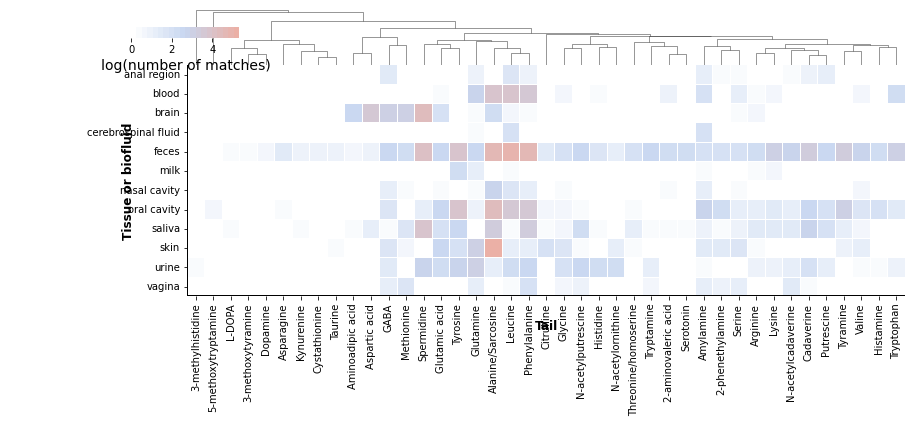

In [6]:
# Heatmap

fig = sns.clustermap(
    log_transformed_data_with_annotations[columns_for_heatmap], 
    cmap=cmap_wbr,
    col_cluster=True, 
    row_cluster=False,
    metric = 'braycurtis',
    yticklabels=log_transformed_data_with_annotations[xaxis],
    linewidths=0.005,
    linecolor = 'white',
    xticklabels=1,
    cbar_kws={'orientation': 'horizontal'}
)

cax = fig.ax_cbar
cax.set_position([.13, .90, .1, .03])  # Adjust the position and size of the color bar

cbar = fig.ax_heatmap.collections[0].colorbar
cbar.set_label('log(number of matches)', fontsize=14)  # Set the desired font size for the color bar label

fig.ax_heatmap.set_xlabel('Tail', fontsize=12, weight='bold')
fig.ax_heatmap.set_ylabel('Tissue or biofluid', fontsize=12, weight='bold', labelpad=-40)
fig.ax_heatmap.xaxis.set_label_coords(0.5, -0.1) #coordinate X axis - more to the bottom
fig.ax_heatmap.yaxis.set_label_coords(-0.09, 0.5) #coordinate X axis - more to the bottom

line_count = len(log_transformed_data_with_annotations['Head'].unique())

# Add an x-axis line at the bottom of the heatmap
fig.ax_heatmap.axhline(y=line_count, color='black', linewidth=2)
# Add a y-axis line on the left side of the heatmap
fig.ax_heatmap.axvline(x=0, color='black', linewidth=2)

fig.ax_heatmap.yaxis.tick_left()

#Resize figure
plt.gcf().set_size_inches(15, 5)

# fig.savefig('/.../Figure1c.pdf')

# N-acyl lipids tail body distribution - Rodents (Supplementary Figure 2d)

In [7]:
#import fastmasst results merged with ReDU - after fultering with cosine > 0.7
df = pd.read_csv('/.../rodents_all_heads_matches_cos07_ReDU_unfiltered07.tsv', sep='\t')

#and create a new column for the chain length
df['tail'] = df['group_annotation'].str.split('-').str[-1]

#and standardize some  UBERONBodyPartName names (combining skin and blood)
df['UBERONBodyPartName'] = df['UBERONBodyPartName'].str.replace('skin of trunk','skin')
df['UBERONBodyPartName'] = df['UBERONBodyPartName'].str.replace('skin of pes','skin')
df['UBERONBodyPartName'] = df['UBERONBodyPartName'].str.replace('head or neck skin','skin')
df['UBERONBodyPartName'] = df['UBERONBodyPartName'].str.replace('axilla skin','skin')
df['UBERONBodyPartName'] = df['UBERONBodyPartName'].str.replace('skin of manus','skin')
df['UBERONBodyPartName'] = df['UBERONBodyPartName'].str.replace('arm skin','skin')
df['UBERONBodyPartName'] = df['UBERONBodyPartName'].str.replace('blood plasma','blood')
df['UBERONBodyPartName'] = df['UBERONBodyPartName'].str.replace('blood serum','blood')

# and remove the ones that will not be informative 
list_remove = ['not applicable', 'not specified', 'ML import: not available'] 
df = df[~df['UBERONBodyPartName'].str.lower().isin(list_remove)]


In [9]:
# Lets get a table with the number of occurrences of each delta_mass per head in microbemasst

#select both groups that we want to plot in the heatmap
yaxis = 'UBERONBodyPartName'       
xaxis = 'Head'

# Group the dataframe by 'Head' and 'delta_mass_round' and count the occurrences
grouped_df = df.groupby([yaxis, xaxis]).size().reset_index(name='count')

# Pivot the grouped dataframe to have 'Head' as columns, 'delta_mass_round' as rows, and 'count' as values
pivot_table = grouped_df.pivot(index = xaxis, columns = yaxis, values='count').fillna(0)

# Reset the index if you want 'delta_mass_round' as a column, not an index
pivot_table.reset_index(inplace=True)
pivot_table.head()

UBERONBodyPartName,Head,adrenal gland,blood,brain,caecum,colon,duodenum,esophagus,feces,gall bladder,...,ovary,pancreas,spleen,stomach,thymus,trachea,upper digestive tract,uterine cervix,uterus,vagina
0,2-aminovaleric acid,0.0,10.0,9.0,2.0,4.0,9.0,0.0,22.0,0.0,...,0.0,0.0,1.0,15.0,1.0,2.0,0.0,0.0,0.0,0.0
1,2-phenethylamine,0.0,1.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3-hydroxykynurenine,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3-methylhistidine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alanine/Sarcosine,0.0,1294.0,0.0,24.0,49.0,69.0,834.0,2843.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# then we need to transpose the dataframe
pivot_table_t = pivot_table.T
pivot_table_t = pivot_table_t.reset_index()
pivot_table_t.columns = pivot_table_t.iloc[0]
pivot_table_t = pivot_table_t[1:]

# to plot counts, we need to convert from object to integer
columns_to_convert = pivot_table_t.columns[1:]
pivot_table_t[columns_to_convert] = pivot_table_t[columns_to_convert].astype(int)
pivot_table_t = pivot_table_t.reset_index()
columns_for_heatmap = pivot_table_t.columns[2:]

#add 1 to all to be able to take log10 after
pivot_table_t[columns_for_heatmap] = pivot_table_t[columns_for_heatmap] + 1

#log10 transform
log_transformed_data = np.log10(pivot_table_t[columns_for_heatmap])
log_transformed_data_with_annotations = pd.concat([pivot_table_t[xaxis], log_transformed_data], axis=1)


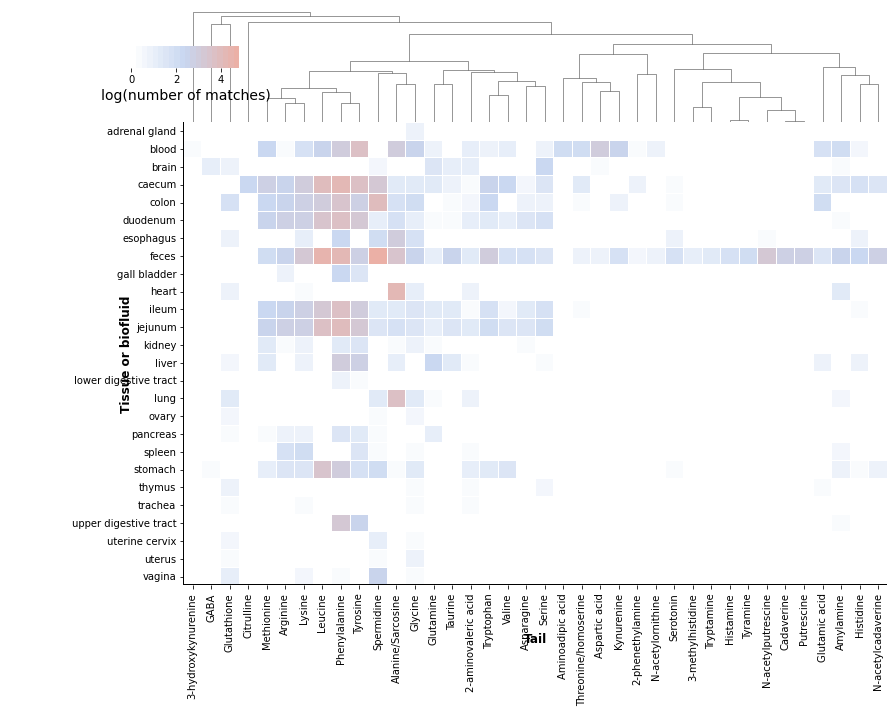

In [12]:
# Heatmap

fig = sns.clustermap(
    log_transformed_data_with_annotations[columns_for_heatmap], 
    cmap=cmap_wbr,
    col_cluster=True, 
    row_cluster=False,
    metric = 'braycurtis',
    yticklabels=log_transformed_data_with_annotations[xaxis],
    linewidths=0.005,
    linecolor = 'white',
    xticklabels=1,
    cbar_kws={'orientation': 'horizontal'}
)

cax = fig.ax_cbar
cax.set_position([.13, .90, .1, .03])  # Adjust the position and size of the color bar

cbar = fig.ax_heatmap.collections[0].colorbar
cbar.set_label('log(number of matches)', fontsize=14)  # Set the desired font size for the color bar label

fig.ax_heatmap.set_xlabel('Tail', fontsize=12, weight='bold')
fig.ax_heatmap.set_ylabel('Tissue or biofluid', fontsize=12, weight='bold', labelpad=-40)
fig.ax_heatmap.xaxis.set_label_coords(0.5, -0.1) #coordinate X axis - more to the bottom
fig.ax_heatmap.yaxis.set_label_coords(-0.09, 0.5) #coordinate X axis - more to the bottom

line_count = len(log_transformed_data_with_annotations['Head'].unique())

# Add an x-axis line at the bottom of the heatmap
fig.ax_heatmap.axhline(y=line_count, color='black', linewidth=2)
# Add a y-axis line on the left side of the heatmap
fig.ax_heatmap.axvline(x=0, color='black', linewidth=2)

fig.ax_heatmap.yaxis.tick_left()

#Resize figure
plt.gcf().set_size_inches(15, 10)

# fig.savefig('/.../Figure1d.pdf')